Description...

In [1]:
import sys
sys.path.append('/lhome/ific/c/ccortesp/Analysis/')

from libs import crudo
from libs import fit_functions as ff
from libs import plotting_tools as pt
from libs import bckg_functions as bf

import argparse
import csv
import glob
from invisible_cities.reco.corrections import read_maps, apply_all_correction
from invisible_cities.types.symbols import NormStrategy
from invisible_cities.core.core_functions import in_range
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.spatial.distance import cdist
from sklearn.neighbors import BallTree
from sklearn.neighbors import NearestNeighbors
from sklearn.exceptions import NotFittedError
from typing import List, Callable, Tuple

# Styling Plot
pt.ccortesp_plot_style()

# Configuration

In [2]:
# OUTPUT FILENAME TAG
# This tag will be added to the output HDF5 filename to version the analysis.
# Avoids overwriting previous results and helps keep track of different cut configurations.
# Example tags: 'other', 'p2_nhit5', 'nhit5_Qthres7' (this is basically p1_nhit5)
VERSION_TAG = 'p2_nhit5_HEscale'

# DIRECTORIES, PATHS & FILES
DATA_DIR   = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Sophronia/Low_background/'
ICAROS_DIR = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Icaros/Low_background/'
OUTPUT_DIR = '/lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Backgrounds/h5/runs/'

RUNS_INFO_PATH = os.path.join('/lhome/ific/c/ccortesp/Analysis/NEXT-100/Backgrounds/utilities/runs_information.csv')

SUMMARY_FILENAME = 'summary_' + VERSION_TAG +'.csv'     # Choose your name
SUMMARY_PATH = os.path.join('/lhome/ific/c/ccortesp/Analysis/NEXT-100/Backgrounds/txt/', SUMMARY_FILENAME)

# KEYS
DORO_KEY = 'DST/Events'
SOPH_KEY = 'RECO/Events'
EVT_KEY  = 'PROCESSED/Events'

# COLUMNS TO USE
DORO_COLUMNS = ['event', 'time', 'nS1', 'nS2', 'S1h', 'S1e', 'S2e', 'DT', 'X', 'Y', 'Z']        # REVISAR SI SE PUEDEN REDUCIR MAS
SOPH_COLUMNS = ['event', 'time', 'npeak', 'X', 'Y', 'Z', 'Q', 'E']

# CUTFLOWS
CUT_NAMES = ['Reconstructed', 'Clean', 'S1_Cut', 'S2_Cut', 'nElectron', 'nAlpha']

# ANALYSIS PARAMETERS
# ----------------------
V_DRIFT = 0.865     # Drift velocity in [mm/μs]

# --- S1 Signal Cuts ---
# Po-like events are filtered using: S1h >= m * S1e + b
M_NOPOLIKE = 0.17
B_NOPOLIKE = -56

# --- S1e Correction ---
DT_STOP = 1372.2543          # Cathode temporal position in [μs]
CV_FIT  = [0.57, 796.53]     # Fit values for S1e correction vs DT

# --- Alpha/Electron Separation Cut ---
# Events with total corrected energy above this threshold are classified as alphas.
ENERGY_THRESHOLD = 7.5e5       # in [PE]

# --- Electron Hit Cleaning Cut ---
# Minimum neighbors hits to define a valid cluster.
N_HITS = 5
# Minimum Q charge to activate a SiPM (P1 = 7 pe, P2 = 5 pe).
Q_THRESHOLD = 5        # in [pe]

# --- Alpha Hit Cleaning Cut ---
# In the alpha population, hits with charge below this value are removed.
Q_LIM_ALPHA = 100      # in [pe]

# --- HE Scale Correction ---
M_HE_SCALE = 4.80e-06
B_HE_SCALE = 0.0094

# --- Isolated/non-isolated Hits --- #
CLUSTER_CONFIG = {"distance": [16., 16., 4.], "nhit": N_HITS}

# --- Trigger 2 Efficiency Cut ---
# Events with event-level energy below this are removed to account for trigger efficiency.
TRG2_THRESHOLD = 0.5   # in [MeV]

# 3. DETECTOR REGIONS
# -------------------
# Geometric boundaries for event classification.
Z_LOW = 40          # in [mm]
Z_UP  = 1147        # in [mm]
R_UP  = 451.65      # in [mm]

# Preliminary

In [3]:
RUN_NUMBER = 15737      # Parse arguments for run number

In [4]:
RUNS_INFO_DF = pd.read_csv(RUNS_INFO_PATH, index_col='run_number')
RUNS_INFO_DF.columns = RUNS_INFO_DF.columns.str.strip()
if RUN_NUMBER not in RUNS_INFO_DF.index:
    print(f"   Error: Run {RUN_NUMBER} not found in runs information.", file=sys.stderr)
    sys.exit(1)
# Extract run information from the dataframe
RUN_DURATION = RUNS_INFO_DF.at[RUN_NUMBER, 'duration']
RUN_OK   = RUNS_INFO_DF.at[RUN_NUMBER, 'OK']
RUN_LOST = RUNS_INFO_DF.at[RUN_NUMBER, 'LOST']

print(f"------ Testing with Run {RUN_NUMBER} ------")
print(f"Duration: {RUN_DURATION} s ({type(RUN_DURATION)}), OK: {RUN_OK} ({type(RUN_OK)}), LOST: {RUN_LOST} ({type(RUN_LOST)})")

kr_file = next((f for f in os.listdir(ICAROS_DIR) if f'run_{RUN_NUMBER}' in f and f.endswith('.map.h5')), None)
if not kr_file:
    raise FileNotFoundError(f"   Error: NO Kr map file found for run {RUN_NUMBER} in {ICAROS_DIR}")
    sys.exit(1)
KR_PATH = os.path.join(ICAROS_DIR, kr_file)
print(f"Kr map file found: {kr_file}")

# Construct specific list of files to process based on run number
files_to_process = []
# ----- LDC Loop ----- #
for ldc in range(1, 8):
    # Load the HDF5 file
    h5_path = os.path.join(DATA_DIR, f'run_{RUN_NUMBER}_ldc{ldc}_trg2_sophronia.h5')
    if os.path.isfile(h5_path):
        files_to_process.append(h5_path)

if not files_to_process:
    print(f"   Error: No .h5 files found to process.", file=sys.stderr)
    sys.exit(1)

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("------------------------------------")
print("Files to Process:")
for fp in files_to_process:
    print(os.path.basename(fp))
print(f"Output Directory: {OUTPUT_DIR}")
print("------------------------------------")

------ Testing with Run 15737 ------
Duration: 52343 s (<class 'numpy.int64'>), OK: 18365 (<class 'numpy.int64'>), LOST: 5844 (<class 'numpy.int64'>)
Kr map file found: run_15737.v2.3.1.20250717.Kr.map.h5
------------------------------------
Files to Process:
run_15737_ldc1_trg2_sophronia.h5
run_15737_ldc2_trg2_sophronia.h5
run_15737_ldc3_trg2_sophronia.h5
run_15737_ldc4_trg2_sophronia.h5
run_15737_ldc5_trg2_sophronia.h5
run_15737_ldc6_trg2_sophronia.h5
run_15737_ldc7_trg2_sophronia.h5
Output Directory: /lustre/ific.uv.es/prj/gl/neutrinos/users/ccortesp/NEXT-100/Backgrounds/h5/runs/
------------------------------------


# Processing

We test on just one H5 file

In [6]:
filepath = files_to_process[0]

### Load Dorothea & Sophronia

In [7]:
df_doro = pd.read_hdf(filepath, key=DORO_KEY).loc[:, DORO_COLUMNS]      # Keep only relevant columns
df_soph = pd.read_hdf(filepath, key=SOPH_KEY).loc[:, SOPH_COLUMNS]      # Keep only relevant columns
df_soph.rename(columns={'Z': 'DT'}, inplace=True)                       # Rename Z to DT for consistency
df_soph['Z'] = df_soph['DT'] * V_DRIFT                                  # Compute real Z position: using the drift velocity

### Energy Correction

In [8]:
df_soph = bf.correct_energy_by_map(df_soph, read_maps(KR_PATH))

In [34]:
# NOTE: This is not a proper test!

# # Global
# n_bins = 35

# # Dataset
# energy_correction_df = df_soph.groupby('event')['X', 'Y', 'Z', 'E_corr'].agg(['mean', 'sum'])
# energy_correction_df.columns = ['_'.join(col).strip() for col in energy_correction_df.columns.values]

# # Variables
# X_evt = energy_correction_df['X_mean']
# Y_evt = energy_correction_df['Y_mean']
# E_evt = energy_correction_df['E_corr_sum']

# # 2D histogram: normalized by corrected DAQ data taking time
# XY_E_map, ex, ey = pt.mapping(X_evt, Y_evt, wei=E_evt, xy_bins=n_bins, norm=True)     
# XY_E_map         = np.ma.masked_where(XY_E_map == 0, XY_E_map)      # Zero values masked

# # ----- Plotting ----- #
# plt.figure(figsize=(6, 6))
# im = plt.pcolormesh(ex, ey, XY_E_map.T, cmap=pt.custom_hsv, shading='auto')
# cbar = plt.colorbar(im, label='Counts', shrink=0.8)
# cbar.formatter.set_powerlimits((-3, 3))
# plt.xlabel('X (mm)')
# plt.ylabel('Y (mm)')

# plt.gca().add_patch(pt.plot_circle(pt.N100_rad, LINESTYLE='-'))
# plt.gca().add_patch(pt.plot_circle(451.65, LINESTYLE='--'))
# plt.gca().set_aspect('equal', adjustable='box')
# plt.gca().set_facecolor("whitesmoke")
# plt.show()

### Basic Cuts & $S1e$ Correction

$Z\,\geq\,0$

In [9]:
current_event_ids = df_soph['event'].unique()
events_with_negative_z_hits = df_soph.loc[df_soph['Z'] < 0, 'event'].unique()
events_with_positive_z_hits = np.setdiff1d(current_event_ids, events_with_negative_z_hits)
Z_pos_doro_df, Z_pos_soph_df = bf.apply_cut_and_update(df_doro, df_soph, event_ids=events_with_positive_z_hits)

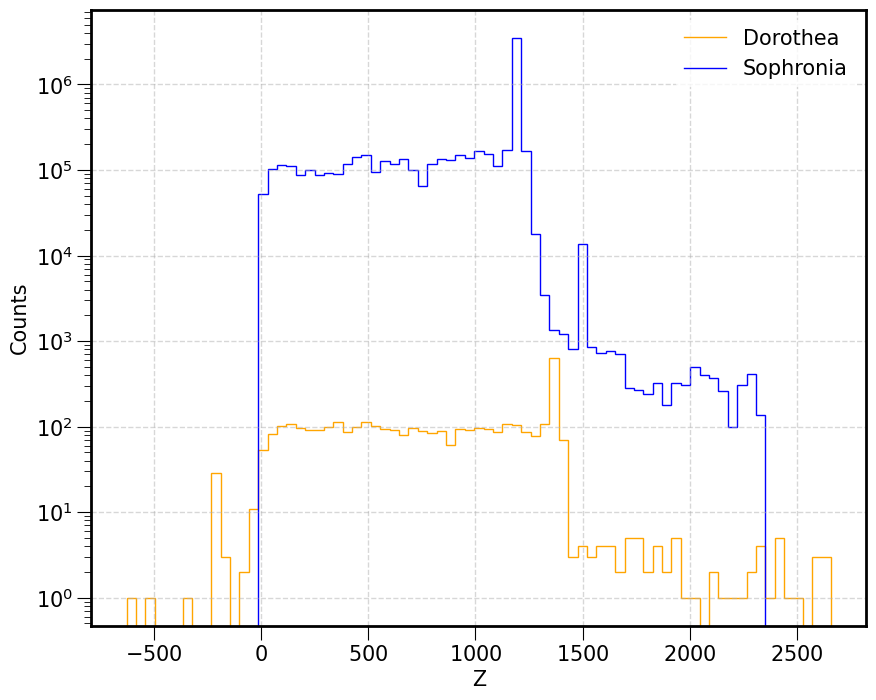

In [10]:
# Drop NaN values from the 'Z' column before creating histograms
Z_doro_clean = Z_pos_doro_df['Z'].dropna()      # nS1 = 0 has NaN Z values
Z_soph_clean = Z_pos_soph_df['Z'].dropna()

# Binning
Z_doro, edges = np.histogram(Z_doro_clean, bins=75)
Z_soph, _     = np.histogram(Z_soph_clean, bins=edges)

plt.stairs(Z_doro, edges, fill=False, ec='orange', lw=1.0, label='Dorothea')
plt.stairs(Z_soph, edges, fill=False, ec='blue', lw=1.0, label='Sophronia')
plt.xlabel('Z')
plt.ylabel('Counts')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
df_doro = Z_pos_doro_df.copy()
df_soph = Z_pos_soph_df.copy()

$nS1\,\leq\,1$ (NO-Polike)

In [12]:
s1_mask = (df_doro['nS1'] == 0) | ((df_doro['nS1'] == 1) & (df_doro['S1h'] >= M_NOPOLIKE * df_doro['S1e'] + B_NOPOLIKE))
S1_doro_df, S1_soph_df = bf.apply_cut_and_update(df_doro, df_soph, cut_mask=s1_mask, df_for_mask=df_doro)

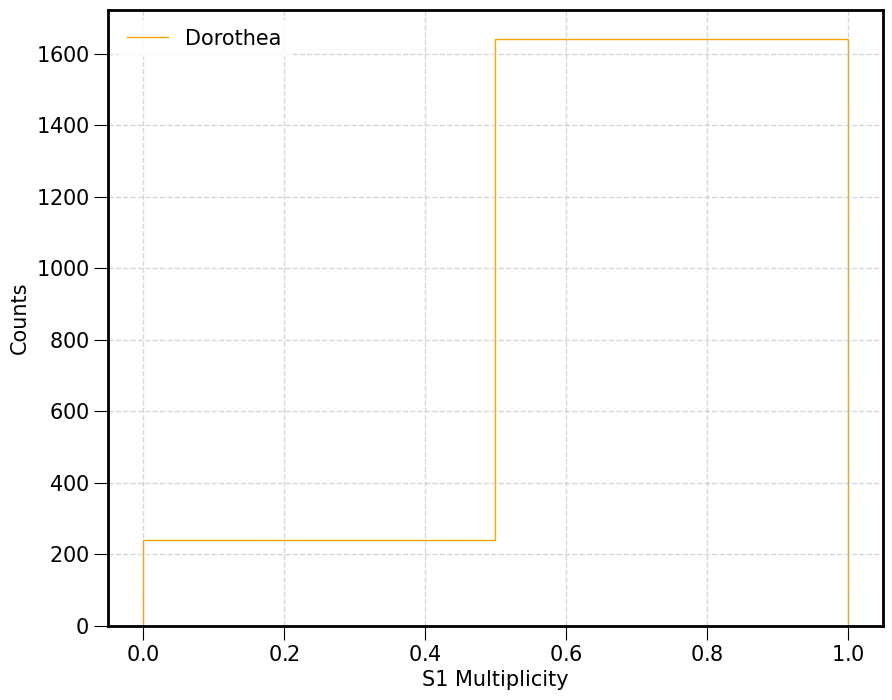

In [13]:
# Binning
nS1_counts, edges = np.histogram(S1_doro_df['nS1'], bins=2)

plt.stairs(nS1_counts, edges, fill=False, ec='orange', lw=1.0, label='Dorothea')
plt.xlabel('S1 Multiplicity')
plt.ylabel('Counts')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

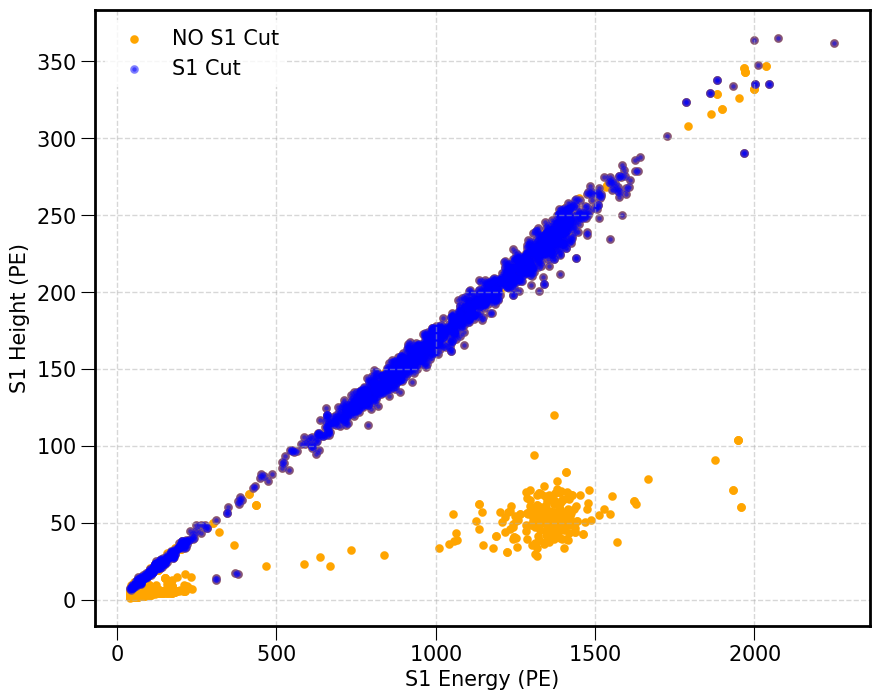

In [14]:
plt.scatter(Z_pos_doro_df['S1e'], Z_pos_doro_df['S1h'], alpha=1.0, s=10, c='orange', label='NO S1 Cut')
plt.scatter(S1_doro_df['S1e'], S1_doro_df['S1h'], alpha=0.5, s=10, c='blue', label='S1 Cut')
plt.xlabel('S1 Energy (PE)')
plt.ylabel('S1 Height (PE)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
df_doro = S1_doro_df.copy()
df_soph = S1_soph_df.copy()

$nS2=1$

In [16]:
s2_mask = (df_doro['nS2'] == 1)
S2_doro_df, S2_soph_df = bf.apply_cut_and_update(df_doro, df_soph, cut_mask=s2_mask, df_for_mask=df_doro)

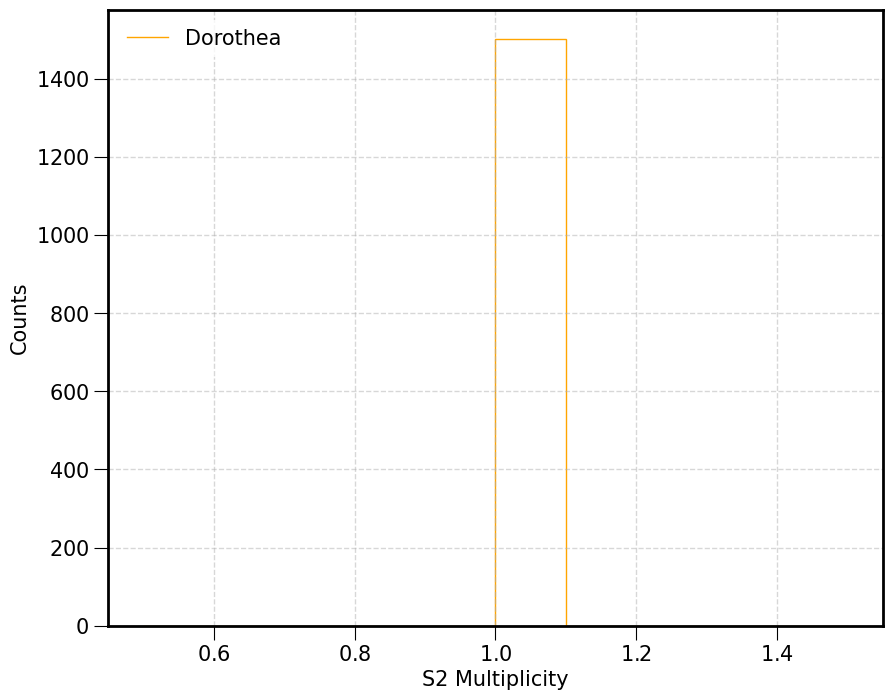

In [17]:
# Binning
nS2_counts, edges = np.histogram(S2_doro_df['nS2'], bins=10)

plt.stairs(nS2_counts, edges, fill=False, ec='orange', lw=1.0, label='Dorothea')
plt.xlabel('S2 Multiplicity')
plt.ylabel('Counts')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [18]:
df_doro = S2_doro_df.copy()
df_soph = S2_soph_df.copy()

#### $S1e$ correction

In [19]:
S1_corr_doro_df = crudo.correct_S1e(df_doro, CV_FIT, DT_STOP, output_column='S1e_corr')     # Based on alpha analysis

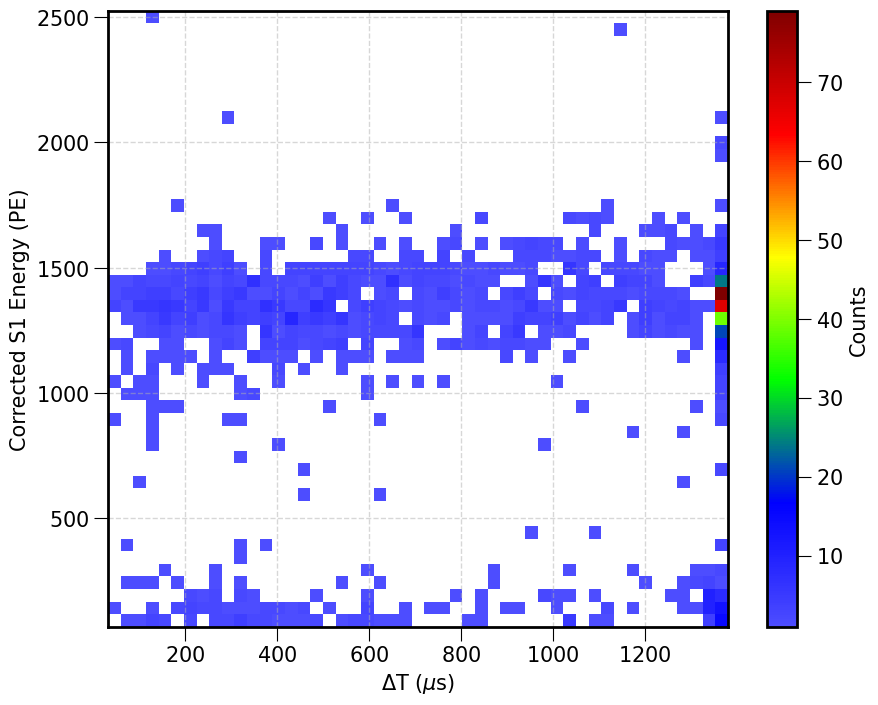

In [30]:
n_bins = 50

E1 = S1_corr_doro_df['S1e_corr']
DT = S1_corr_doro_df['DT']
R  = np.sqrt(S1_corr_doro_df['X']**2 + S1_corr_doro_df['Y']**2)

# Masking
# rad_mask = (R <= R_UP)
# dt_mask  = (DT <= DT_STOP)
# E1 = E1[rad_mask & dt_mask]
# DT = DT[rad_mask & dt_mask]

# 2D histogram
S1e_DT_map, ex, ey = pt.hist_2D(DT, E1, x_bins=n_bins, y_bins=n_bins)                          
S1e_DT_map         = np.ma.masked_where(S1e_DT_map==0, S1e_DT_map)                # Zero values masked

plt.pcolormesh(ex, ey, S1e_DT_map.T, cmap=pt.custom_hsv, shading='auto')    
cbar = plt.colorbar(label='Counts', shrink=1.0)
plt.xlabel('$\Delta$T ($\mu$s)')
plt.ylabel('Corrected S1 Energy (PE)')
plt.grid(True)
plt.show()

In [31]:
df_doro = S1_corr_doro_df.copy()

### Particle Tagging & Processing

In [40]:
soph_tagged_df = bf.tag_particles(df_soph, energy_threshold=ENERGY_THRESHOLD)
print(f"Energy Threshold for Alpha/Electron Separation: {ENERGY_THRESHOLD} PE")

df_electron = soph_tagged_df[soph_tagged_df['particle'] == 'electron'].copy()
df_alpha    = soph_tagged_df[soph_tagged_df['particle'] == 'alpha'].copy()

Energy Threshold for Alpha/Electron Separation: 750000.0 PE


How is the energy spectrum?

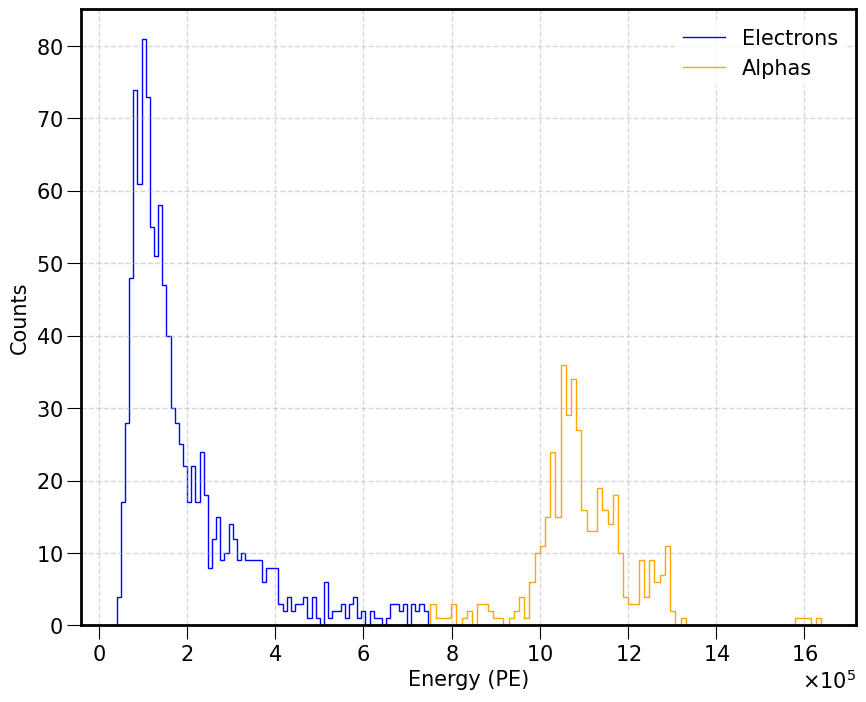

In [49]:
E_electron_evt_NO_clean = df_electron.groupby('event')['E_corr'].sum()
E_alpha_evt_NO_clean    = df_alpha.groupby('event')['E_corr'].sum()

# Binning
E_electron, e_elec = np.histogram(E_electron_evt_NO_clean, bins=75)
E_alpha, e_alphas  = np.histogram(E_alpha_evt_NO_clean, bins=75)

plt.stairs(E_electron, e_elec, fill=False, ec='blue', lw=1.0, label='Electrons')
plt.stairs(E_alpha, e_alphas, fill=False, ec='orange', lw=1.0, label='Alphas')
plt.xlabel('Energy (PE)')
plt.ylabel('Counts')
plt.ticklabel_format(axis='x', style='sci', scilimits=(5, 5))
plt.legend()
plt.grid(True)
plt.show()

How do they look?

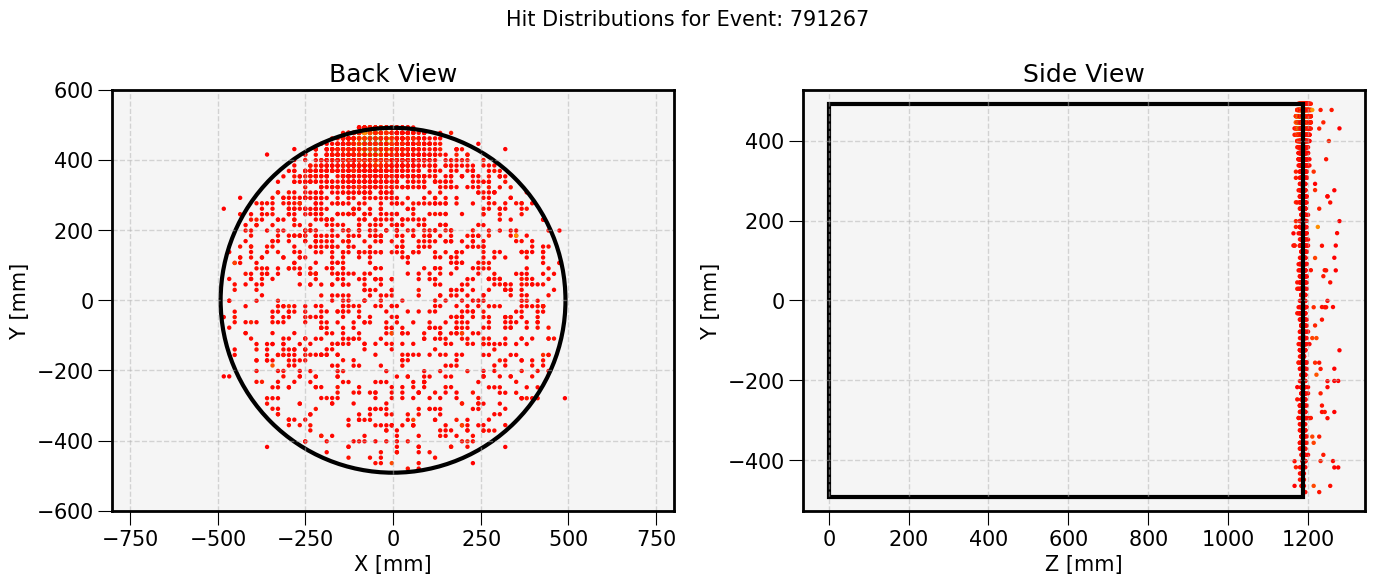

In [165]:
pt.event_display(df_electron, event=791267)

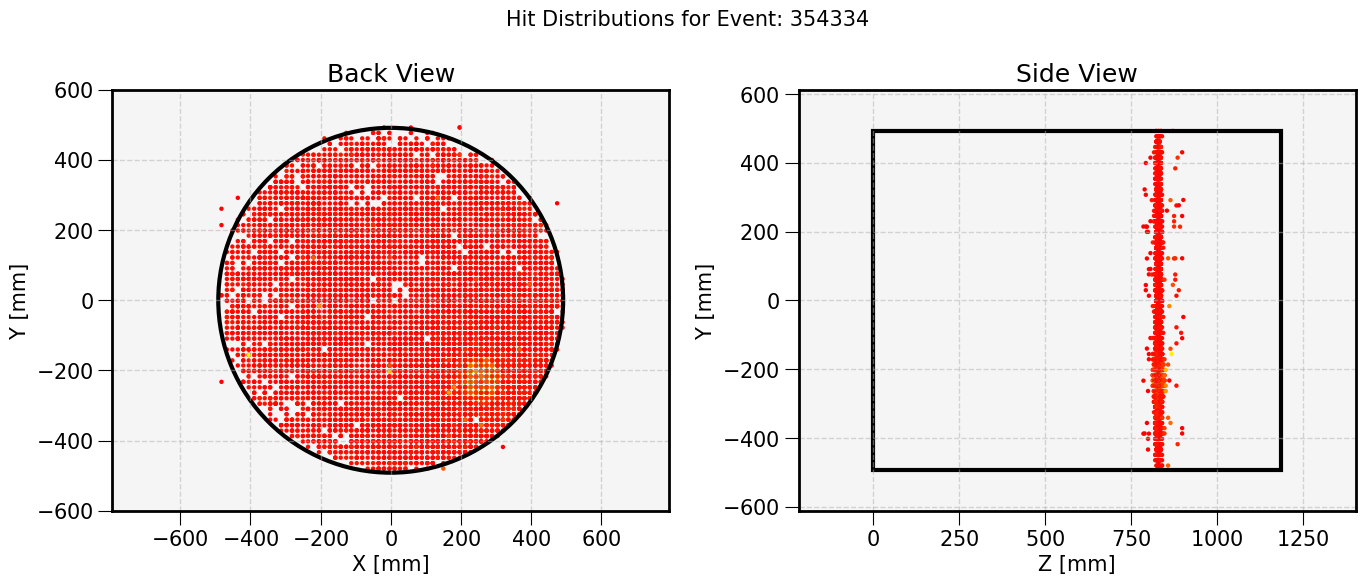

In [243]:
pt.event_display(df_alpha, event=354334)

#### Cleaning spurious hits

In [120]:
final_electron_df = bf.process_electrons(df_electron, cluster_config=CLUSTER_CONFIG)
final_alpha_df    = bf.process_alphas(df_alpha, q_threshold=Q_LIM_ALPHA)

How is the energy spectrum?

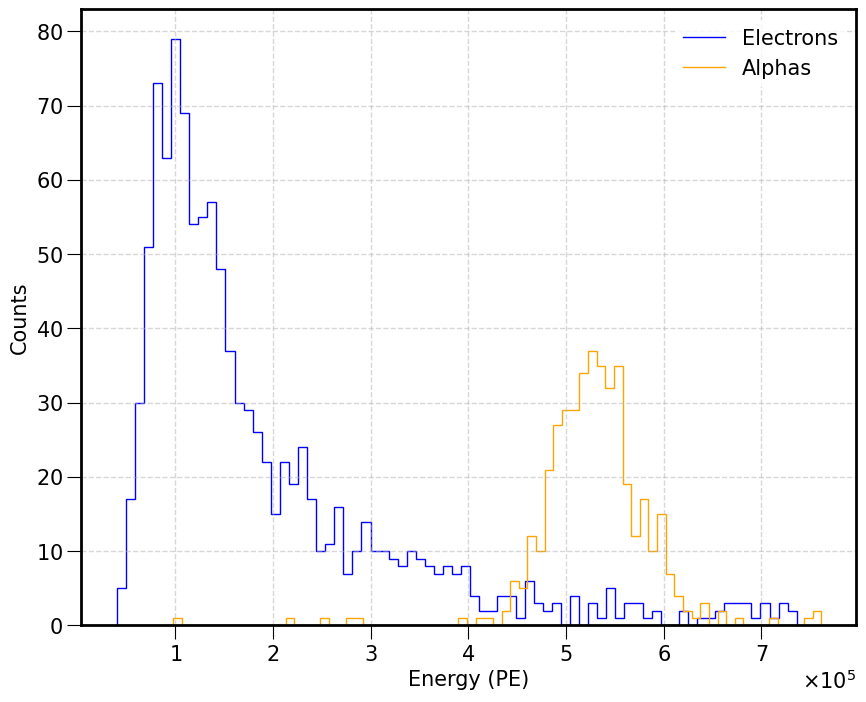

In [122]:
E_electron_evt_clean = final_electron_df.groupby('event')['E_hit_pe'].sum()
E_alpha_evt_clean    = final_alpha_df.groupby('event')['E_hit_pe'].sum()

# Binning
E_electron, e_elec = np.histogram(E_electron_evt_clean, bins=75)
E_alpha, e_alphas  = np.histogram(E_alpha_evt_clean, bins=75)

plt.stairs(E_electron, e_elec, fill=False, ec='blue', lw=1.0, label='Electrons')
plt.stairs(E_alpha, e_alphas, fill=False, ec='orange', lw=1.0, label='Alphas')
plt.xlabel('Energy (PE)')
plt.ylabel('Counts')
plt.ticklabel_format(axis='x', style='sci', scilimits=(5, 5))
plt.legend()
plt.grid(True)
plt.show()

How do they look?

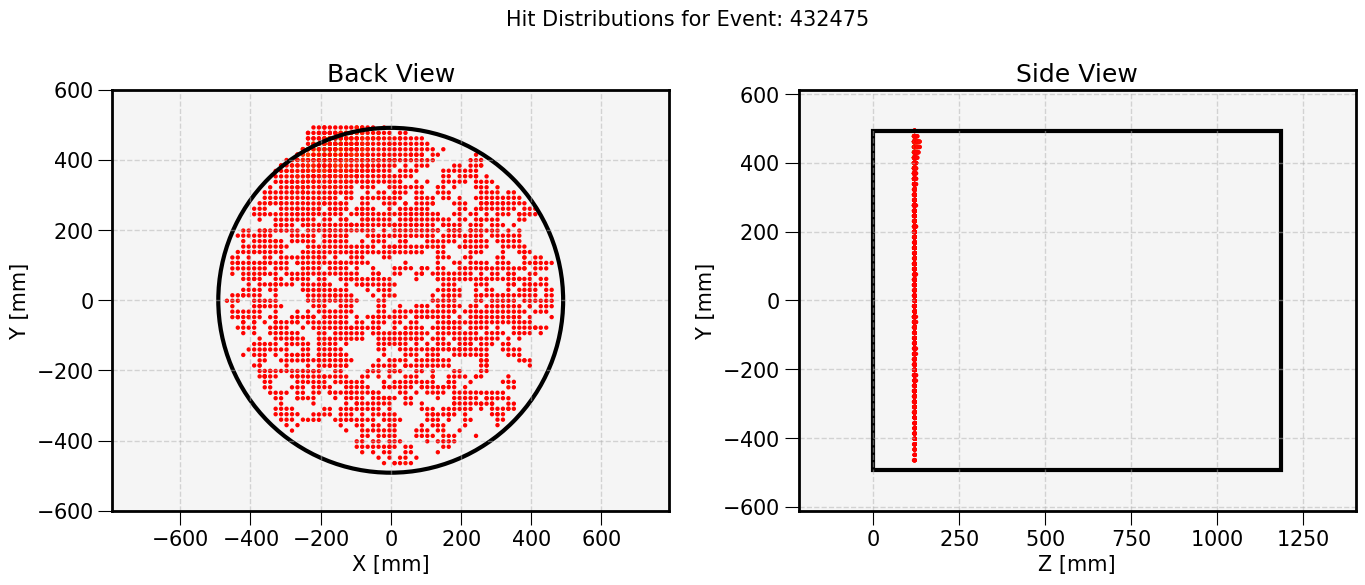

In [175]:
pt.event_display(final_electron_df)

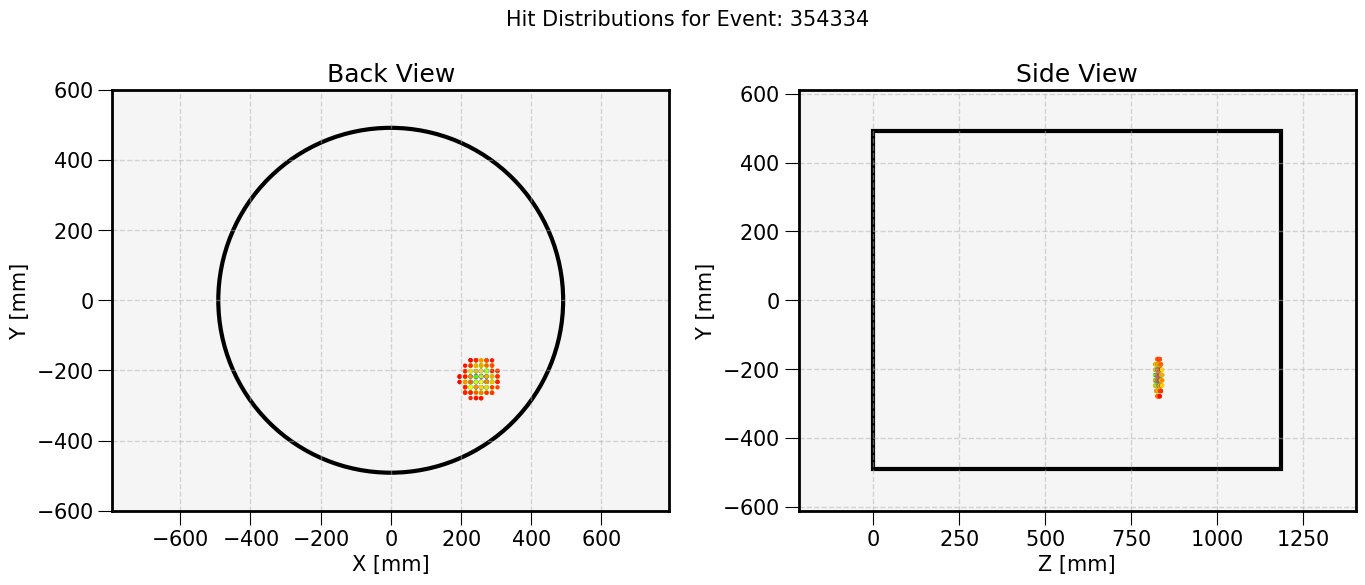

In [242]:
pt.event_display(final_alpha_df)

Final Sophronia merged dataframe

In [244]:
df_soph_final = pd.concat([final_electron_df, final_alpha_df], ignore_index=True, sort=False)

### Data @ Event-level

In [252]:
df_event_final = bf.aggregate_to_event_level(df_soph_final, df_doro)

Use the HE scale!

In [253]:
df_event_final =  bf.energy_pe_to_mev(df_event_final, slope=M_HE_SCALE, intercept=B_HE_SCALE)
print(f"HE Scale Function: E (MeV) = {M_HE_SCALE}*E_pe + {B_HE_SCALE}")

HE Scale Function: E (MeV) = 4.8e-06*E_pe + 0.0094


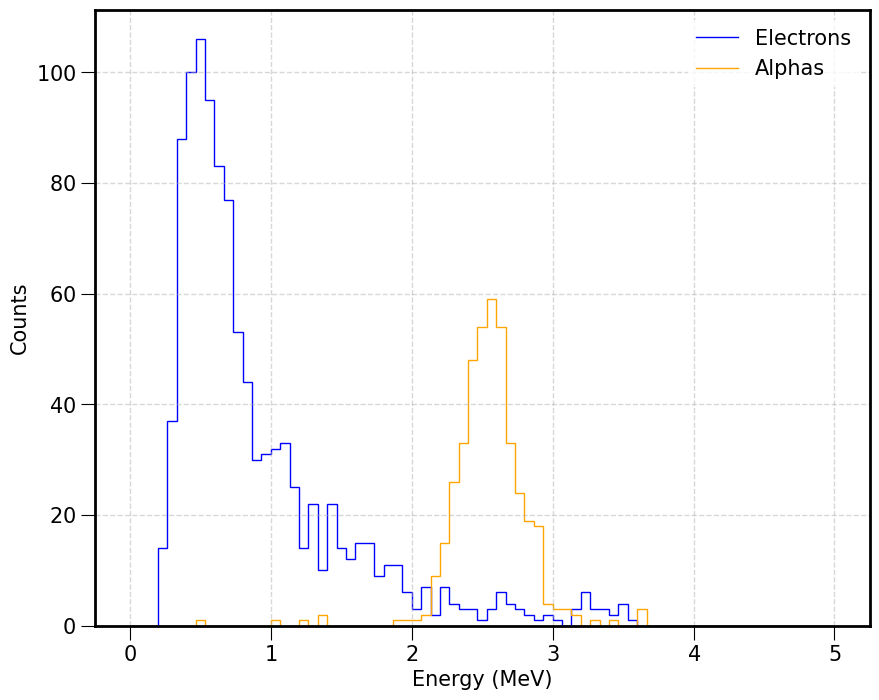

In [257]:
E_electrons_MeV = df_event_final[df_event_final['particle'] == 'electron']['E_mev']
E_alphas_MeV    = df_event_final[df_event_final['particle'] == 'alpha']['E_mev']

# Binning
n_bins = 75
x_min, x_max = 0, 5
x_edges = np.linspace(x_min, x_max, n_bins + 1)

elec_counts, _  = np.histogram(E_electrons_MeV, bins=x_edges)
alpha_counts, _ = np.histogram(E_alphas_MeV, bins=x_edges)

plt.stairs(elec_counts, x_edges, fill=False, ec='blue', lw=1.0, label='Electrons')
plt.stairs(alpha_counts, x_edges, fill=False, ec='orange', lw=1.0, label='Alphas')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.legend()
plt.grid(True)
plt.show()

# Selection

The available dataframes after processing are:

In [261]:
df_event_final

,event,npeak,time,X_bary,Y_bary,Z_bary,E_pe,Z_min,Z_max,R_max,particle,nS1,nS2,S1e,S1e_corr,E_mev
0,596,34,1.759250e+09,277.210374,213.075879,1185.590400,507099.946474,1175.148561,1198.790633,403.258517,alpha,1,1,1390.610352,1391.372306,2.443480
1,5013,34,1.759250e+09,396.958270,165.432649,1188.445199,667558.198681,1171.992284,1209.448839,500.123641,electron,1,1,1178.166016,1177.874377,3.213679
2,5363,27,1.759250e+09,23.678237,-131.820802,1184.127114,546871.587004,1171.155721,1198.210867,195.175732,alpha,1,1,1395.159790,1396.781582,2.634384
3,6399,36,1.759250e+09,112.203223,406.883718,285.934136,387463.908382,278.649046,294.639436,507.085748,electron,1,1,871.523254,1396.749559,1.869227
4,8093,36,1.759250e+09,292.341335,336.315420,974.123283,117401.710261,957.721729,987.893037,498.606966,electron,1,1,1171.508789,1285.323897,0.572928
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,1782810,26,1.759302e+09,-101.985640,153.652645,41.912350,117250.132892,33.092197,59.595148,318.737692,electron,0,1,NaN,NaN,0.572201
1498,1786828,24,1.759302e+09,104.454907,383.819434,1185.171305,527072.776063,1173.860036,1197.496161,458.100623,alpha,1,1,1322.344360,1323.308166,2.539349
1499,1787647,26,1.759302e+09,-409.682839,99.866861,53.012899,83341.209002,50.032898,59.133130,491.115309,electron,0,1,NaN,NaN,0.409438
1500,1789054,19,1.759302e+09,172.553648,75.344064,51.635223,115687.099821,35.779319,66.387236,265.710465,electron,0,1,NaN,NaN,0.564698


In [263]:
df_soph_final

,event,time,npeak,X,Y,DT,Q,E,Z,corr_factor,E_corr,particle,E_hit_pe
0,5013,1.759250e+09,34,396.725,153.125,1354.904375,5.919895,97.662164,1171.992284,1.243382,121.431375,electron,131.178878
1,5013,1.759250e+09,34,396.725,168.675,1354.904375,13.078516,215.759931,1171.992284,1.269777,273.966974,electron,295.958770
2,5013,1.759250e+09,34,396.725,184.225,1354.904375,11.157342,184.065786,1171.992284,1.318453,242.681996,electron,262.162494
3,5013,1.759250e+09,34,412.275,137.575,1354.904375,5.715142,94.284290,1171.992284,1.284449,121.103406,electron,130.824583
4,5013,1.759250e+09,34,412.275,153.125,1354.904375,15.269380,251.903220,1171.992284,1.315926,331.486043,electron,358.094993
...,...,...,...,...,...,...,...,...,...,...,...,...,...
758008,1786828,1.759302e+09,24,88.725,399.425,1384.388625,149.623138,841.497112,1197.496161,1.212176,1020.042438,alpha,1020.042438
758009,1786828,1.759302e+09,24,104.275,383.875,1384.388625,189.585892,1066.252065,1197.496161,1.207213,1287.193529,alpha,1287.193529
758010,1786828,1.759302e+09,24,104.275,399.425,1384.388625,169.835663,955.174589,1197.496161,1.234818,1179.467016,alpha,1179.467016
758011,1786828,1.759302e+09,24,119.825,383.875,1384.388625,166.572403,936.821654,1197.496161,1.228344,1150.739293,alpha,1150.739293


### Trigger2 Cut

In [264]:
trg2_mask = (df_event_final['E_mev'] >= TRG2_THRESHOLD)
trg2_event_df, trg2_soph_df = bf.apply_cut_and_update(df_event_final, df_soph_final, cut_mask=trg2_mask, df_for_mask=df_event_final)
print(f"Trigger 2 Efficiency Cut applied at {TRG2_THRESHOLD} MeV")

Trigger 2 Efficiency Cut applied at 0.5 MeV


In [278]:
trg2_counts = trg2_event_df['particle'].value_counts()
print(f"Particle counts:\n{trg2_counts}")
print(f"This is how you access to the electron count ({trg2_counts.get('electron', 0)}) and alpha count ({trg2_counts.get('alpha', 0)})")

Particle counts:
electron    793
alpha       418
Name: particle, dtype: int64
This is how you access to the electron count (793) and alpha count (418)


In [301]:
df_event_final = trg2_event_df.copy()
df_soph_final  = trg2_soph_df.copy()

### Detector Region Tagging

In [280]:
event_region_tags = bf.tag_event_by_detector_region(df_event_final, z_cut_low=Z_LOW, z_cut_high=Z_UP, r_cut_high=R_UP)

Are these tags ok?

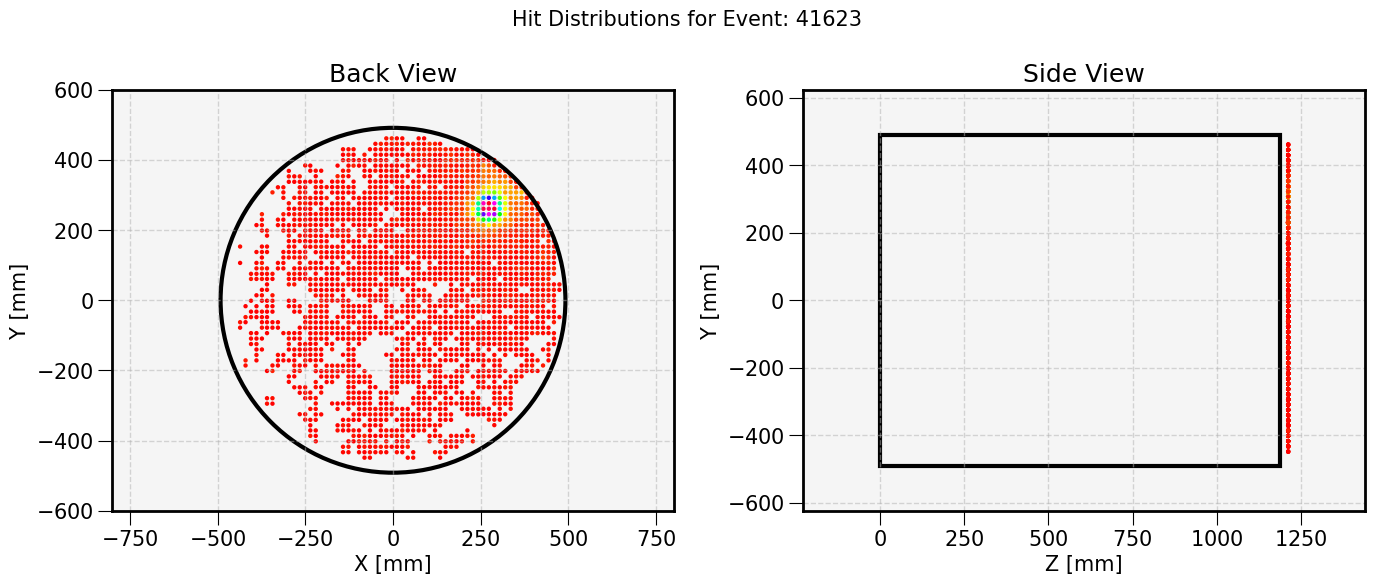

In [293]:
pt.event_display(df_soph_final, event=41623)

Now let's save the information into the dataframes

In [302]:
df_event_final['region'] = event_region_tags.values
df_soph_final = df_soph_final.merge(df_event_final[['event', 'region']], on='event', how='left')

And also, let's find the event counters

In [313]:
detector_region_counts = df_event_final.groupby(['particle', 'region'])['event'].nunique()
detector_region_counts

particle  region  
alpha     anode         9
          cathode     273
          fiducial    101
          tube         35
electron  anode        75
          cathode      73
          fiducial     24
          tube        621
Name: event, dtype: int64

In [ ]:
test_df = df_event_final[(df_event_final['particle'] == 'electron') & (df_event_final['region'] == 'cathode')].copy()
test_df.event.nunique()

73

In [314]:
detector_region_counts.get(('electron', 'cathode'), 0)

73

In [319]:
# Verificar si hay columnas con tipo uint64
uint64_columns = df_event_final.select_dtypes(include=['uint64']).columns
print("Columnas con tipo uint64:", uint64_columns)

Columnas con tipo uint64: Index(['npeak'], dtype='object')
